# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

We'll also provide our OpenAI key, as well as our Cohere API key.

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [2]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using our Loan Data once again - this time the strutured data available through the CSV!

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

In [3]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.document_loaders import TextLoader


path = "../rag_dataset/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
txt_loader = DirectoryLoader(path, glob="**/*.txt", loader_cls=TextLoader,
)

docs = loader.load()
txt = txt_loader.load()
all_docs = docs + txt

print(f"Loaded {len(docs)} PDFs + {len(txt)} TXTs  →  {len(all_docs)} documents")

Loaded 85 PDFs + 1 TXTs  →  86 documents


Let's look at an example document to see if everything worked as expected!

In [4]:
all_docs[0]

Document(metadata={'producer': 'macOS Version 14.4.1 (Build 23E224) Quartz PDFContext', 'creator': 'TextEdit', 'creationdate': "D:20250804232836Z00'00'", 'source': '../rag_dataset/finance_rag_corpus_nycfine.pdf', 'file_path': '../rag_dataset/finance_rag_corpus_nycfine.pdf', 'total_pages': 7, 'format': 'PDF 1.3', 'title': 'finance_rag_corpus_nycfine', 'author': '', 'subject': '', 'keywords': '', 'moddate': "D:20250804232836Z00'00'", 'trapped': '', 'modDate': "D:20250804232836Z00'00'", 'creationDate': "D:20250804232836Z00'00'", 'page': 0}, page_content='=== policy_manual_v1_1 (policy, None, internal) ===\nNYC Fine Jewelry\nFinance & Accounting Policy Manual\nEffective: January 1, 2025   •   Version: 1.1\nTable of Contents\n1. Purpose & Scope\n2. Revenue Recognition Policy\n3. Inventory & Cost of Goods Sold (COGS)\n4. Capital Expenditure & Depreciation\n5. Budgeting & Forecasting Guidelines\n6. Variance Analysis & Management Commentary\n7. Expense & Procurement Policy\n8. Internal Control

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "LoanComplaints".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [5]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    all_docs,
    embeddings,
    location=":memory:",
    collection_name="FinanceDocs"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [6]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [7]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind accounting and finance expert. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [8]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [9]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [10]:
naive_retrieval_chain.invoke({"question" : "How was my performance in May 2025?"})["response"].content

'Your performance in May 2025 can be assessed based on several indicators and key financial activities documented for that period:\n\n1. **Financial Performance:**\n   - The revenue variance was approximately -4% versus forecast due to production delays from equipment maintenance.\n   - Gross margin experienced a slight decline of 2 percentage points, mainly due to a mix shift toward higher-margin pieces.\n   - Operating expenses were under budget by about 9%, driven by timing differences in marketing spend.\n   - Key KPIs such as sales ($420,000), gross margin percentage (60.7%), EBITDA ($54,000), and cash balance ($118,000) indicate positive movement and close alignment with targets.\n\n2. **Operational Actions & Oversight:**\n   - The marketing spend was over budget by USD 4,000 because of increased CPM costs on Instagram ads; a campaign report was requested to provide further context.\n   - The management team recognized the production delays and took steps to adjust forecasts and 

In [11]:
naive_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided context, there are multiple references to timely handling of expenses and reports, with some discussions about delays and the importance of timely disclosures. However, there is no explicit mention of complaints related to customer service or internal complaints not being handled in a timely manner.\n\nTherefore, I do not know if any complaints did not get handled in a timely manner.'

In [12]:
naive_retrieval_chain.invoke({"question" : "When do I earn revenues?"})["response"].content

'You earn revenues when you provide goods or services to your customers and they gain control over the delivered goods or services. This typically occurs at the point when the transfer of control happens, which could be upon shipment, delivery, or in-store pickup, depending on your revenue recognition policy. In essence, revenue is recognized when your company satisfies its performance obligations and the customer has the ability to direct the use and obtain benefits from the goods or services.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [13]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(all_docs, )

We'll construct the same chain - only changing the retriever.

In [14]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [15]:
bm25_retrieval_chain.invoke({"question" : "How was my performance in May 2025?"})["response"].content

'Based on the provided context, I do not have specific information related to your personal performance in May 2025.'

In [16]:
bm25_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided document, there is no explicit information indicating that any complaints about handling were not addressed in a timely manner.'

In [17]:
bm25_retrieval_chain.invoke({"question" : "When do I earn revenues?"})["response"].content

'Revenues are earned when the entity has satisfied the performance obligations to transfer goods or services to customers, meaning the entity has generally completed its part of the transaction and has a legal right to payment. In accounting terms, revenues are recognized in the period when the entity satisfies these obligations, which typically aligns with the transfer of control to the customer.\n\nPlease note that the provided document primarily discusses expense disaggregation and disclosure requirements, with some references to revenue recognition principles. It emphasizes that revenues are recognized when performance obligations are met, rather than at the moment of cash receipt or other timing points.\n\nIf you need more specific guidance based on a particular situation or accounting standard, please let me know!'

It's not clear that this is better or worse, if only we had a way to test this (SPOILERS: We do, the second half of the notebook will cover this)

#### ❓ Question #1:

Give an example query where BM25 is better than embeddings and justify your answer.

****

BM25 excels at exact keyword matching, so it’s more likely to retrieve documents that contain words that the query literally has

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [18]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-v3.5")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [19]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [20]:
contextual_compression_retrieval_chain.invoke({"question" : "How was my performance in May 2025?"})["response"].content

"Based on the provided internal management commentary and financial data for May 2025, here's an overview of your performance:\n\n- Revenue declined slightly by 4% compared to forecast, primarily due to production delays caused by equipment maintenance.\n- Gross margin experienced a minor decrease of 2 percentage points, influenced by a shift toward higher-margin pieces.\n- Operating expenses were 9% below plan, mainly due to timing of marketing spend.\n- Action items included updating forecasts to current run-rate, reordering fast-moving SKUs to prevent stock-outs, and monitoring gold prices for hedging considerations.\n\nOverall, your performance in May 2025 shows a slight deviation from forecasted revenue but effective management of costs. The proactive steps outlined suggest a focus on maintaining operational efficiency and readiness for market fluctuations.\n\nIf you're looking for a specific performance metric or financial ratio, please specify."

In [ ]:
contextual_compression_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

In [ ]:
contextual_compression_retrieval_chain.invoke({"question" : "When do I earn revenues?"})["response"].content

'Revenues are earned when control of the goods or services transfers to the customer. Specifically, for NYC Fine Jewelry, revenue is recognized at the point when the product is shipped (upon shipment from the FOB shipping point) or when the customer picks up the product in-store. This means that you "earn" revenues at the moment the company has fulfilled its performance obligation and the customer gains control of the product.'

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [ ]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [ ]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [ ]:
multi_query_retrieval_chain.invoke({"question" : "How was my performance in May 2025?"})["response"].content

'Based on the provided documentation, your performance in May 2025 can be summarized as follows:\n\n1. Revenue Impact:\n- The revenue variance for May 2025 was a decrease of about 4% compared to the forecast, primarily due to production delays caused by equipment maintenance.\n\n2. Gross Margin:\n- The gross margin variance was a decline of 2 percentage points, with a mix shift toward higher-margin pieces partially offsetting the margin impact of production issues.\n\n3. Operating Expenses:\n- Operating expenses were 9% below plan, mainly due to timing differences in marketing spend.\n\n4. Key Activities and Response:\n- Marketing overspend in May due to increased CPM on Instagram ads (tracking USD 4k over budget), with plans to monitor ROAS and cap spend if necessary.\n- The management team proactively adjusted forecasts, reordered fast-moving SKUs to prevent stock-outs, and continued monitoring gold prices for hedging.\n\n5. Financial Highlights:\n- Monthly sales for July 2025 reache

In [ ]:
multi_query_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided context, there are multiple indications that certain complaints or variances related to timely handling of issues, specifically in the context of expense management, forecasts, and stock-outs, have been addressed through action items and management commentary. For example, in the management commentary for each month, variances exceeding thresholds prompt specific action items such as adjusting forecasts, re-ordering SKUs, and monitoring gold prices regularly.\n\nHowever, the context does not explicitly specify whether any complaints from external stakeholders or customers directly did not get handled in a timely manner. The discussions primarily focus on internal management variances, forecasts, expense disaggregation, and internal policies without clear mention of unresolved complaints or issues.\n\nTherefore, I do not know if any complaints did not get handled in a timely manner, based on the information provided.'

In [ ]:
multi_query_retrieval_chain.invoke({"question" : "When do I earn revenues?"})["response"].content

'You earn revenues when your company transfers control of goods or services to your customers, typically at the point of shipment (for shipped goods) or when the customer picks up the product in-store. In other words, revenue recognition occurs when the company has fulfilled its performance obligation and the customer gains control, net of any returns, allowances, or sales taxes.'

#### ❓ Question #2:

Explain how generating multiple reformulations of a user query can improve recall.

****

Captures synonyms and paraphrases

Reformulations allow the retriever to explore different angles or interpretations of the question, reducing the risk of missing useful information
Bypasses vocabulary mismatches: Users and documents often use different terminology


## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [ ]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = all_docs
child_splitter = RecursiveCharacterTextSplitter(chunk_size=750)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [ ]:
from langchain_qdrant import QdrantVectorStore

client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = QdrantVectorStore(
    collection_name="full_documents", embedding=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [ ]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [ ]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [ ]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [ ]:
parent_document_retrieval_chain.invoke({"question" : "How was my performance in May 2025?"})["response"].content

"Based on the management commentary provided for May 2025, your company's performance in that month showed the following key points:\n\n- Revenue was approximately 4% below the forecast due to production delays caused by equipment maintenance.\n- Gross margin slightly decreased by 2 percentage points, primarily due to a shift in product mix toward higher-margin pieces.\n- Operating expenses were about 9% lower than planned, mainly because of timing differences in marketing spend.\n\nOverall, the performance experienced some variances from projections, mainly related to operational disruptions and timing of expenditures. The management's action items included adjusting forecasts based on updated run rates, reordering fast-moving SKUs to prevent stock-outs, and monitoring gold prices for hedging if volatility continues.\n\nIf you are seeking a more detailed or specific assessment, please let me know!"

In [ ]:
parent_document_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided context, there is no explicit information indicating that any complaints about handling were not addressed in a timely manner. Therefore, I do not know if any complaints did not get handled promptly.'

In [ ]:
parent_document_retrieval_chain.invoke({"question" : "When do I earn revenues?"})["response"].content

'You earn revenues when control of the product transfers to the customer, which typically occurs upon shipment (for FOB shipping point) or in-store pickup. This means revenue is recognized at the point when the customer gains legal right to the goods and the company has fulfilled its primary performance obligation, such as dispatching the product or the customer collecting it. Additionally, revenue is measured net of returns, allowances, and sales taxes, and there is a cut-off policy that revenue from shipments dispatched or picked up on or before the last day of the month is recognized within that period.'

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [ ]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [ ]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [ ]:
ensemble_retrieval_chain.invoke({"question" : "How was my performance in May 2025?"})["response"].content

'Based on the provided information, I do not have specific data or metrics about your individual performance in May 2025. The documents and summaries focus on company-wide financials, variances, management commentary, and policies from that period, but they do not include personal performance assessments or KPIs related to your role or contributions.\n\nIf you have specific performance indicators or areas you want to evaluate, please provide those details, and I would be happy to assist!'

In [ ]:
ensemble_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided context, there is no explicit information indicating that any complaints were not handled in a timely manner. The documents focus primarily on accounting standards, disclosures, reporting requirements, and internal policies, without mention of complaint management or timeliness of responses.\n\nTherefore, I do not know if any complaints did not get handled in a timely manner.'

In [ ]:
ensemble_retrieval_chain.invoke({"question" : "When do I earn revenues?"})["response"].content

'Revenues are earned when control transfers to the customer. According to the policy, this typically occurs upon shipment of the product (at FOB shipping point) or when the customer picks up the product in-store. The company recognizes revenue at the point when these control transfer events happen, and the revenue is measured net of returns, allowances, and sales taxes. Additionally, revenue is recognized during the cut-off period, meaning shipments dispatched or pickups completed on or before the last day of the month belong to that period’s revenue.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [ ]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [ ]:
semantic_documents = semantic_chunker.split_documents(all_docs[:20])

Let's create a new vector store.

In [ ]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="Finance_Data_Semantic_Chunks"
)

We'll use naive retrieval for this example.

In [ ]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [ ]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [ ]:
semantic_retrieval_chain.invoke({"question" : "How was my performance in May 2025?"})["response"].content

"Based on the provided context, your performance in May 2025 included several notable points:\n\n1. **Revenue Variance:** There was a decrease of 4% vs forecast, primarily due to production delays caused by equipment maintenance.\n2. **Gross Margin:** Slight decrease of 2 percentage points, with a mix shift toward higher-margin pieces.\n3. **Operating Expenses (OPEX):** Actual expenses were 9% lower than planned, mainly due to timing differences in marketing spend.\n\nAdditionally, there was internal communication regarding overspending in marketing, with a noted over-budget of approximately USD 4,000 due to a spike in CPM for Instagram ads, and discussions on adjusting forecasts and reordering SKUs.\n\nOverall, your sales and margins faced some challenges but also showed areas of positive variance, such as reduced operating expenses. The company actively monitored gold prices and adjusted forecasts accordingly.\n\nIf you are looking for a specific assessment of your individual perform

In [ ]:
semantic_retrieval_chain.invoke({"question" : "Did any complaints not get handled in a timely manner?"})["response"].content

'Based on the provided context, there is no explicit information indicating that any complaints were not handled in a timely manner. Therefore, I do not know if any complaints did not get handled on time.'

In [ ]:
semantic_retrieval_chain.invoke({"question" : "When do I earn revenues?"})["response"].content

'You earn revenues when you transfer control of goods or services to the customer, which typically occurs upon shipment (if shipping terms are FOB shipping point) or when the customer picks up the product in-store. Revenue is recognized at this point regardless of whether the cash has been received, as long as the company has transferred control of the product or service. Additionally, revenue is measured net of returns, allowances, and sales taxes. Gift card breakage revenue is recognized when the probability of redemption becomes remote, estimated at 24 months of inactivity.'

#### ❓ Question #3:

If sentences are short and highly repetitive (e.g., FAQs), how might semantic chunking behave, and how would you adjust the algorithm?

****

Few “semantic shifts” detected -> very long chunks
When each sentence has nearly identical embeddings (because wording and topics repeat), the similarity curve stays flat. The percentile‐based breakpoint detector may decide no point is different enough, so it merges many sentences into one oversized chunk.
Tiny embedding distances dominated by noise
If every sentence is only a line or two, the cosine‑distance signal that the splitter watches becomes extremely small—sometimes smaller than embedding noise—so breakpoints fluctuate unpredictably.
Context windows wasted on duplicate information
A chunk stuffed with 20 near‑identical FAQ lines gives the LLM less useful variety than a mixed‑topic chunk of the same length.

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

In [ ]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [ ]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(all_docs[:20], testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/15 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/20 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node


Applying SummaryExtractor:   0%|          | 0/29 [00:00<?, ?it/s]

Property 'summary' already exists in node '6f493e'. Skipping!
Property 'summary' already exists in node 'a9ef51'. Skipping!
Property 'summary' already exists in node '52ce79'. Skipping!
Property 'summary' already exists in node '242034'. Skipping!
Property 'summary' already exists in node '379a7c'. Skipping!
Property 'summary' already exists in node 'd043f2'. Skipping!
Property 'summary' already exists in node '30468a'. Skipping!
Property 'summary' already exists in node '7f713b'. Skipping!
Property 'summary' already exists in node '348be1'. Skipping!
Property 'summary' already exists in node '7649f1'. Skipping!
Property 'summary' already exists in node '535ef6'. Skipping!
Property 'summary' already exists in node '1ee1c2'. Skipping!
Property 'summary' already exists in node '9b88e3'. Skipping!
Property 'summary' already exists in node 'a76bfd'. Skipping!


Applying CustomNodeFilter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/33 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node '6f493e'. Skipping!
Property 'summary_embedding' already exists in node '7f713b'. Skipping!
Property 'summary_embedding' already exists in node '52ce79'. Skipping!
Property 'summary_embedding' already exists in node '9b88e3'. Skipping!
Property 'summary_embedding' already exists in node '242034'. Skipping!
Property 'summary_embedding' already exists in node '348be1'. Skipping!
Property 'summary_embedding' already exists in node 'a9ef51'. Skipping!
Property 'summary_embedding' already exists in node '379a7c'. Skipping!
Property 'summary_embedding' already exists in node 'a76bfd'. Skipping!
Property 'summary_embedding' already exists in node '7649f1'. Skipping!
Property 'summary_embedding' already exists in node '30468a'. Skipping!
Property 'summary_embedding' already exists in node '535ef6'. Skipping!
Property 'summary_embedding' already exists in node '1ee1c2'. Skipping!
Property 'summary_embedding' already exists in node 'd043f2'. Sk

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,How are joint venturers involved in the manage...,[obligations. Corporate Joint Venture A corpor...,Joint venturers are entities that own and oper...,single_hop_specifc_query_synthesizer
1,who is joint venturers and what they do in cor...,[obligations. Corporate Joint Venture A corpor...,Joint venturers is the small group of entities...,single_hop_specifc_query_synthesizer
2,In the context of evaluating corporate joint v...,[obligations. Corporate Joint Venture A corpor...,"According to the provided context, a governmen...",single_hop_specifc_query_synthesizer
3,What is a Defined Contribution Plan and how ar...,[Defined Contribution Plan A plan that provide...,A Defined Contribution Plan is a plan that pro...,single_hop_specifc_query_synthesizer
4,What is a Defined Contribution Plan and how ar...,[Defined Contribution Plan A plan that provide...,A Defined Contribution Plan is a plan that pro...,single_hop_specifc_query_synthesizer
5,Could you explain in detail what a Defined Con...,[Defined Contribution Plan A plan that provide...,A Defined Contribution Plan is a type of benef...,single_hop_specifc_query_synthesizer
6,What distinguishes a corporate joint venture f...,[<1-hop>\n\nobligations. Corporate Joint Ventu...,A corporate joint venture is a corporation own...,multi_hop_abstract_query_synthesizer
7,whts the diffrnce betwen a defined benefit pla...,[<1-hop>\n\nobligations. Corporate Joint Ventu...,A defined benefit plan gives participants a de...,multi_hop_abstract_query_synthesizer
8,What is the difference between a defined benef...,[<1-hop>\n\nobligations. Corporate Joint Ventu...,A defined benefit plan provides participants w...,multi_hop_abstract_query_synthesizer
9,How does a defined contribution plan differ fr...,[<1-hop>\n\nobligations. Corporate Joint Ventu...,A defined contribution plan provides an indivi...,multi_hop_abstract_query_synthesizer


In [ ]:
def retrieve(state):
  retrieved_docs = semantic_retrieval_chain.invoke(state["question"])
  return {"context" : retrieved_docs}

In [ ]:
# only for parent_document_retriever

from operator import itemgetter
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import (
    RunnableParallel,   # mapping-as-runnable
    RunnableLambda,     # small Python lambda wrapper
)
from langchain.chat_models import ChatOpenAI

# ----- pieces -------------------------------------------------------------
answer_prompt = PromptTemplate.from_template(
    """You are a helpful finance assistant.
    <context>
    {context}
    </context>
    Question: {question}
    Answer in 1-2 concise paragraphs."""
)

llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

def _join_docs(d):          # helper to concat page_content
    return {
        "question": d["question"],
        "context_str": "\n\n".join(doc.page_content for doc in d["context"]),
        "context": d["context"],        # keep raw docs for later
    }

# ----- runnable chain -----------------------------------------------------
rag_chain = (
    RunnableParallel(                       # step 1: fetch docs
        question=itemgetter("question"),
        context=itemgetter("question") | parent_document_retriever,
    )
    | RunnableLambda(_join_docs)            # step 2: format context
    | RunnableParallel(                     # step 3: answer + passthrough docs
        response=(
            {"context": itemgetter("context_str"), "question": itemgetter("question")}
            | answer_prompt
            | llm
        ),
        context=itemgetter("context"),
    )
)

# ----- evaluation loop ----------------------------------------------------
for test_row in dataset:
    result = rag_chain.invoke({"question": test_row.eval_sample.user_input})

    test_row.eval_sample.response           = result["response"]
    test_row.eval_sample.retrieved_contexts = [
        doc.page_content for doc in result["context"]
    ]

/var/folders/ht/fl04k8nn1176mv3fk6kyhkzr0000gn/T/ipykernel_69676/3623245385.py:21: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)


In [ ]:
for test_row in dataset:
  response = semantic_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [ ]:
dataset.samples[0].eval_sample.response

AIMessage(content='In a corporate joint venture, joint venturers are actively involved in both the management and ownership of the venture. They typically own equity interests in the venture and share in the associated risks and rewards. Importantly, joint venturers usually participate in the overall management of the joint venture, either directly or indirectly, rather than remaining passive investors. This involvement can include decision-making authority, strategic planning, and operational oversight. Ownership of the venture is often represented by equity interests that are not publicly traded and tend to remain relatively stable over time, although minority public ownership is possible. Overall, joint venturers have a substantive relationship with the joint venture, actively contributing to its management, rather than merely providing capital.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 139, 'prompt_tokens': 5377, 'total_tokens': 

In [ ]:
type(dataset)

ragas.testset.synthesizers.testset_schema.Testset

In [ ]:
from ragas import EvaluationDataset

evaluation_dataset = dataset.to_pandas()
evaluation_dataset["response"] = evaluation_dataset["response"].apply(lambda r: r["content"] if isinstance(r, dict) and "content" in r else r)
evaluation_dataset = EvaluationDataset.from_pandas(evaluation_dataset)

/Users/germee/Desktop/desktop/courses/aie7-certification/Task6_Advanced_Retrieval/.venv/lib/python3.13/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=AIMessage(content='In a c...o': 0, 'reasoning': 0}}), input_type=AIMessage])
  return self.__pydantic_serializer__.to_python(
/Users/germee/Desktop/desktop/courses/aie7-certification/Task6_Advanced_Retrieval/.venv/lib/python3.13/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=AIMessage(content='In the...o': 0, 'reasoning': 0}}), input_type=AIMessage])
  return self.__pydantic_serializer__.to_python(
/Users/germee/Desktop/desktop/courses/aie7-certification/Task6_Advanced_Retrieval/.venv/lib/python3.13/site-packages/pydantic/main.py:463: UserWarning: Pydantic seria

In [ ]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))

In [ ]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig
import time

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
)
result

Evaluating:   0%|          | 0/66 [00:00<?, ?it/s]

Exception raised in Job[1]: TimeoutError()
Exception raised in Job[4]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[7]: TimeoutError()
Exception raised in Job[8]: TimeoutError()
Exception raised in Job[10]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[13]: TimeoutError()
Exception raised in Job[14]: TimeoutError()
Exception raised in Job[17]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()
Exception raised in Job[65]: TimeoutError()


{'context_recall': 0.9545, 'faithfulness': 0.8149, 'factual_correctness': 0.5089, 'answer_relevancy': 0.9657, 'context_entity_recall': 0.4167, 'noise_sensitivity_relevant': 0.7692}

In [ ]:
import pandas as pd

# 1) Convert the RAGAS EvaluationResult to a DataFrame
df = result.to_pandas()          # one row per sample, one column per metric  :contentReference[oaicite:0]{index=0}

# 2) Keep only the numeric metric columns (in case your dataset columns are mixed in)
metric_cols = df.select_dtypes(include="number").columns

# 3) Nice console display of per-sample scores
print("\nPer-sample metrics")
print(df[metric_cols].to_string(index=False, float_format="%.4f"))

# 4) Compute aggregate (mean) scores and show them as a tidy one-column table
overall = df[metric_cols].mean().to_frame(name="avg_score")
print("\nAggregate scores")
print(overall.to_string(float_format="%.4f"))


Per-sample metrics
 context_recall  faithfulness  factual_correctness  answer_relevancy  context_entity_recall  noise_sensitivity_relevant
         1.0000           NaN               0.6700            0.9422                    NaN                         NaN
         1.0000           NaN                  NaN            0.9533                    NaN                         NaN
         0.5000           NaN                  NaN            0.9611                 0.6667                         NaN
         1.0000        1.0000               0.2400            0.9812                 1.0000                      0.7692
         1.0000        0.9615               0.3100            0.9802                 1.0000                         NaN
         1.0000        0.9250               0.3800            0.9639                 1.0000                         NaN
         1.0000        0.8611               0.5900            0.9805                 0.0000                         NaN
         1.0000     

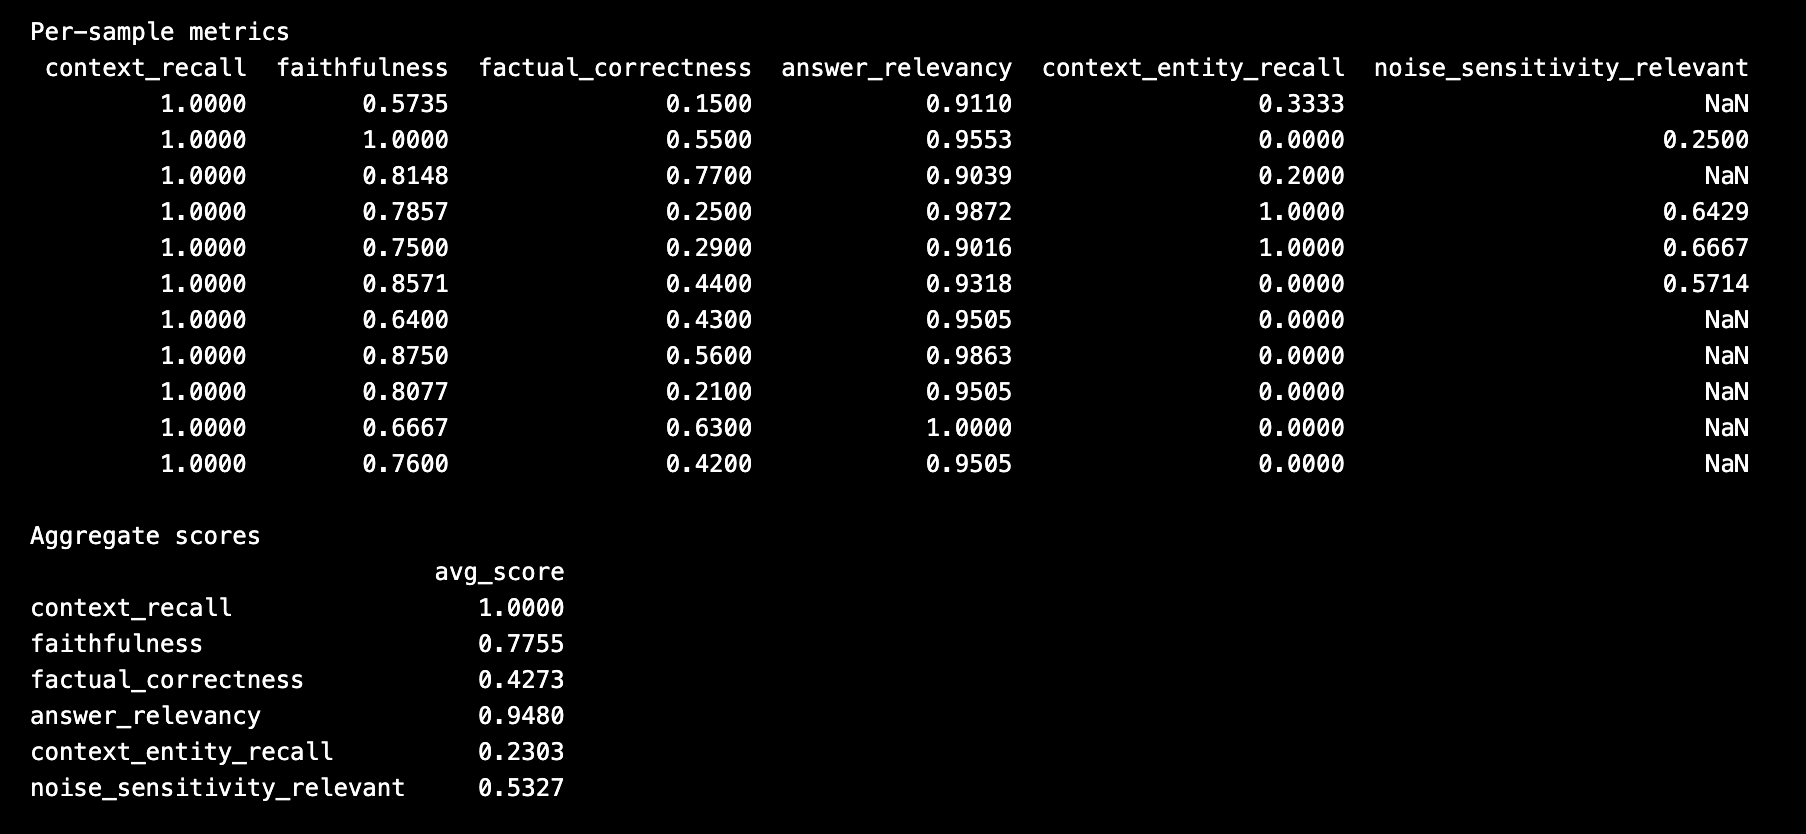

In [ ]:
## naive retrieval

from IPython.display import Image, display

display(Image(filename="ragas/1naive.png"))


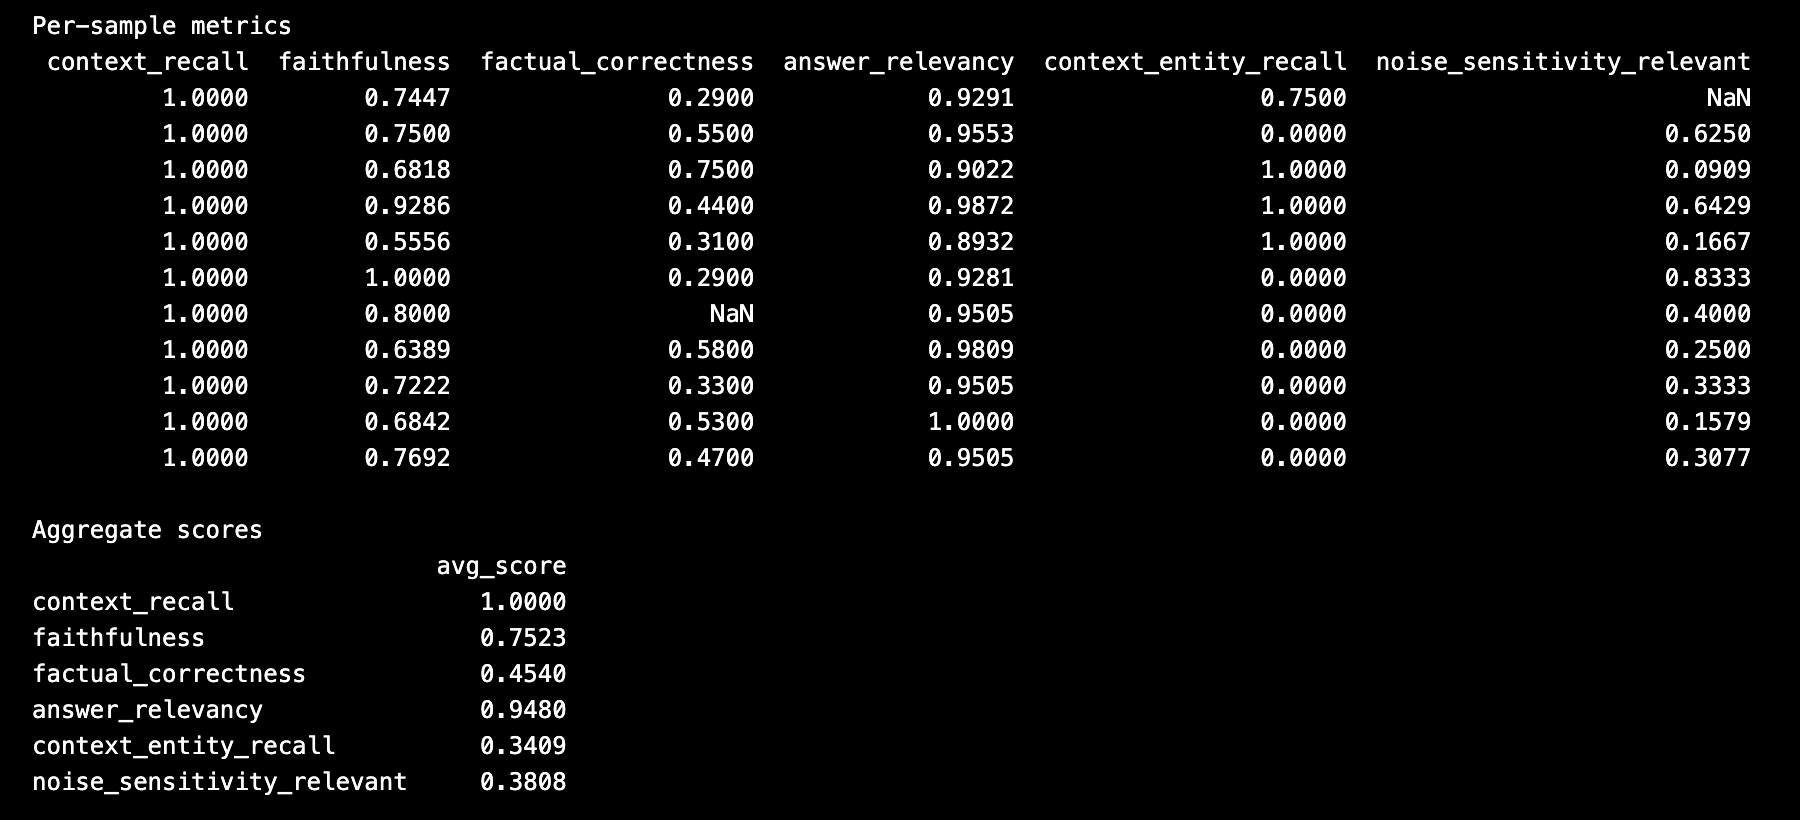

In [ ]:
## bm25

from IPython.display import Image, display

display(Image(filename="ragas/2bm25.png"))

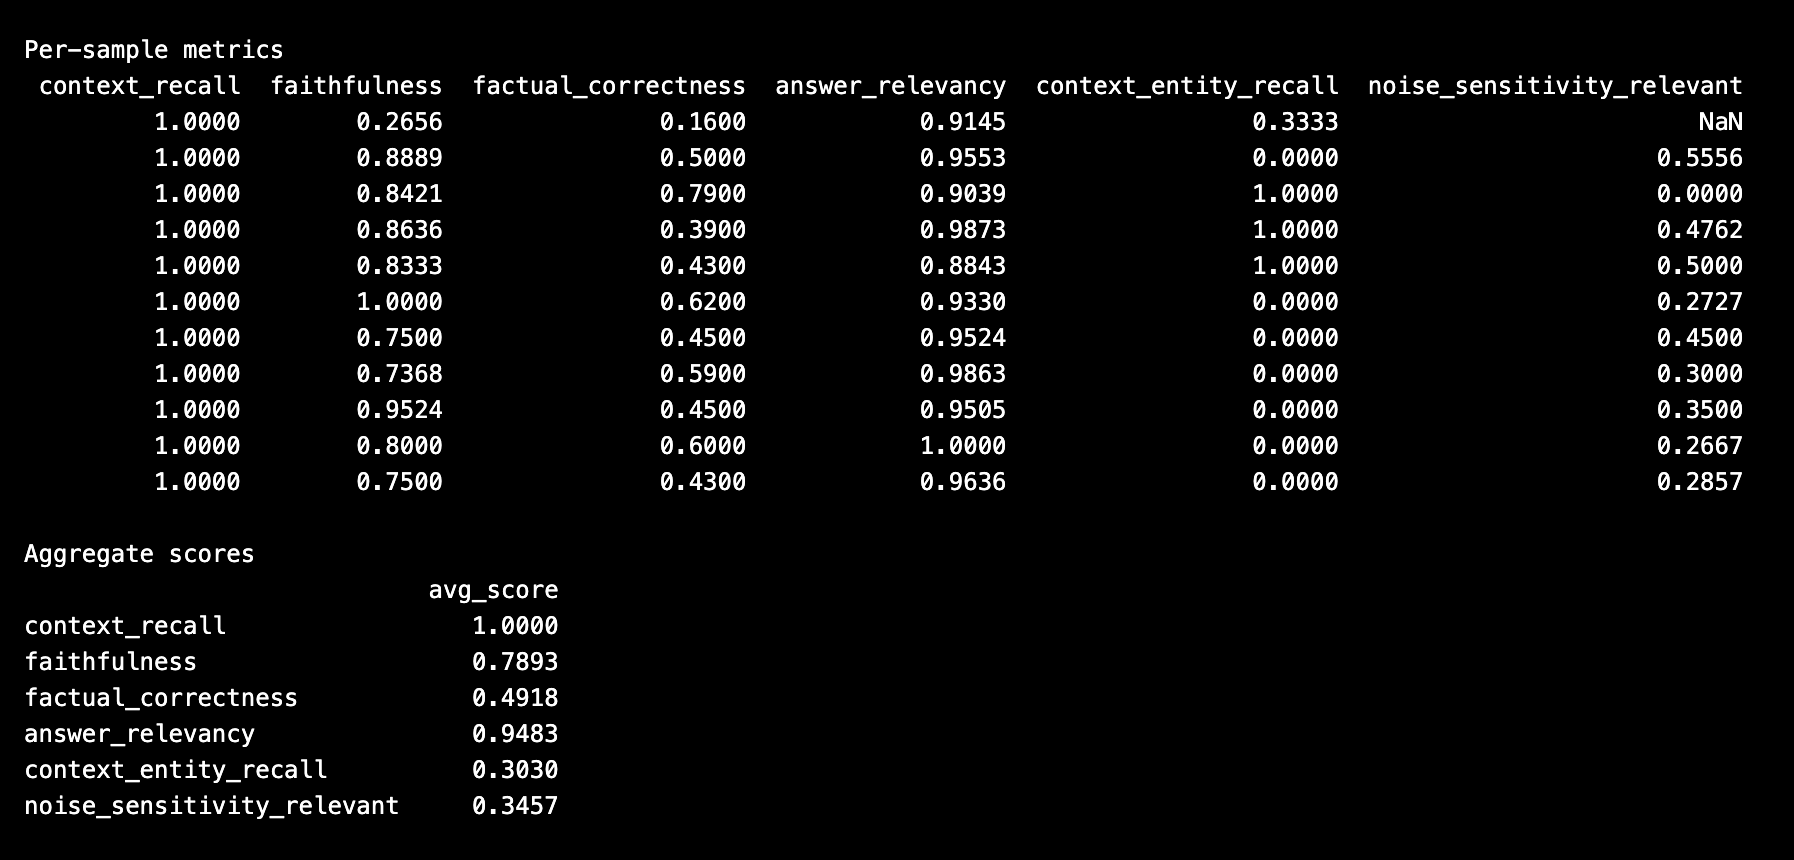

In [ ]:
## contextual compression

from IPython.display import Image, display

display(Image(filename="ragas/3contextualcompression.png"))

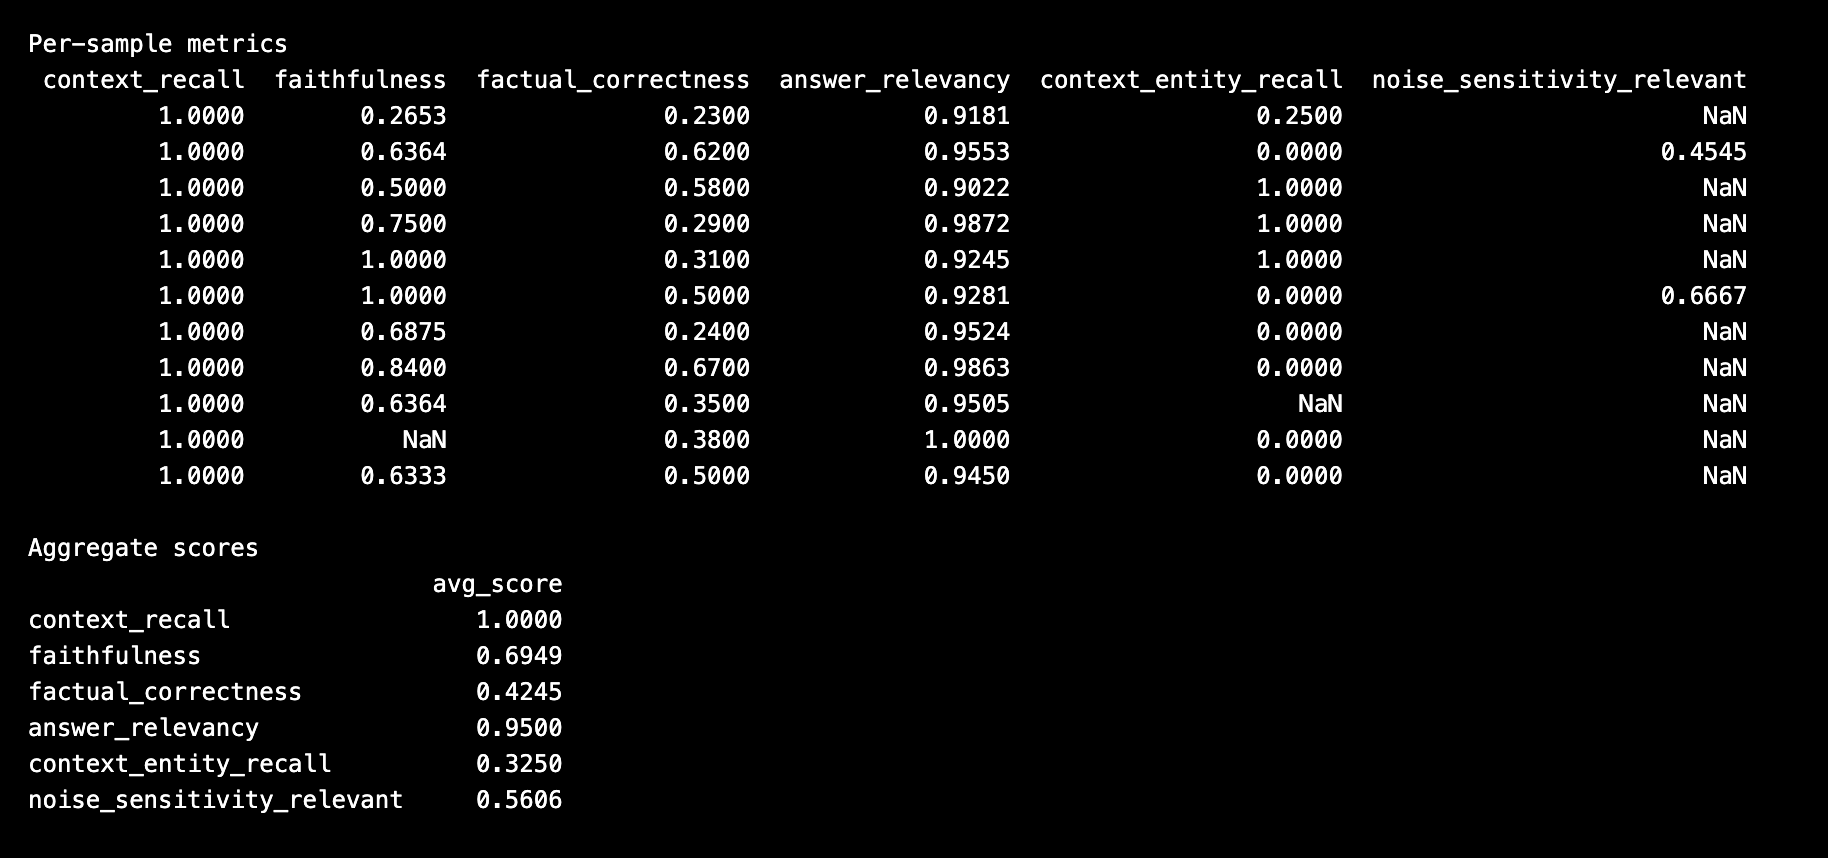

In [ ]:
## multi-query

from IPython.display import Image, display

display(Image(filename="ragas/4multiquery.png"))

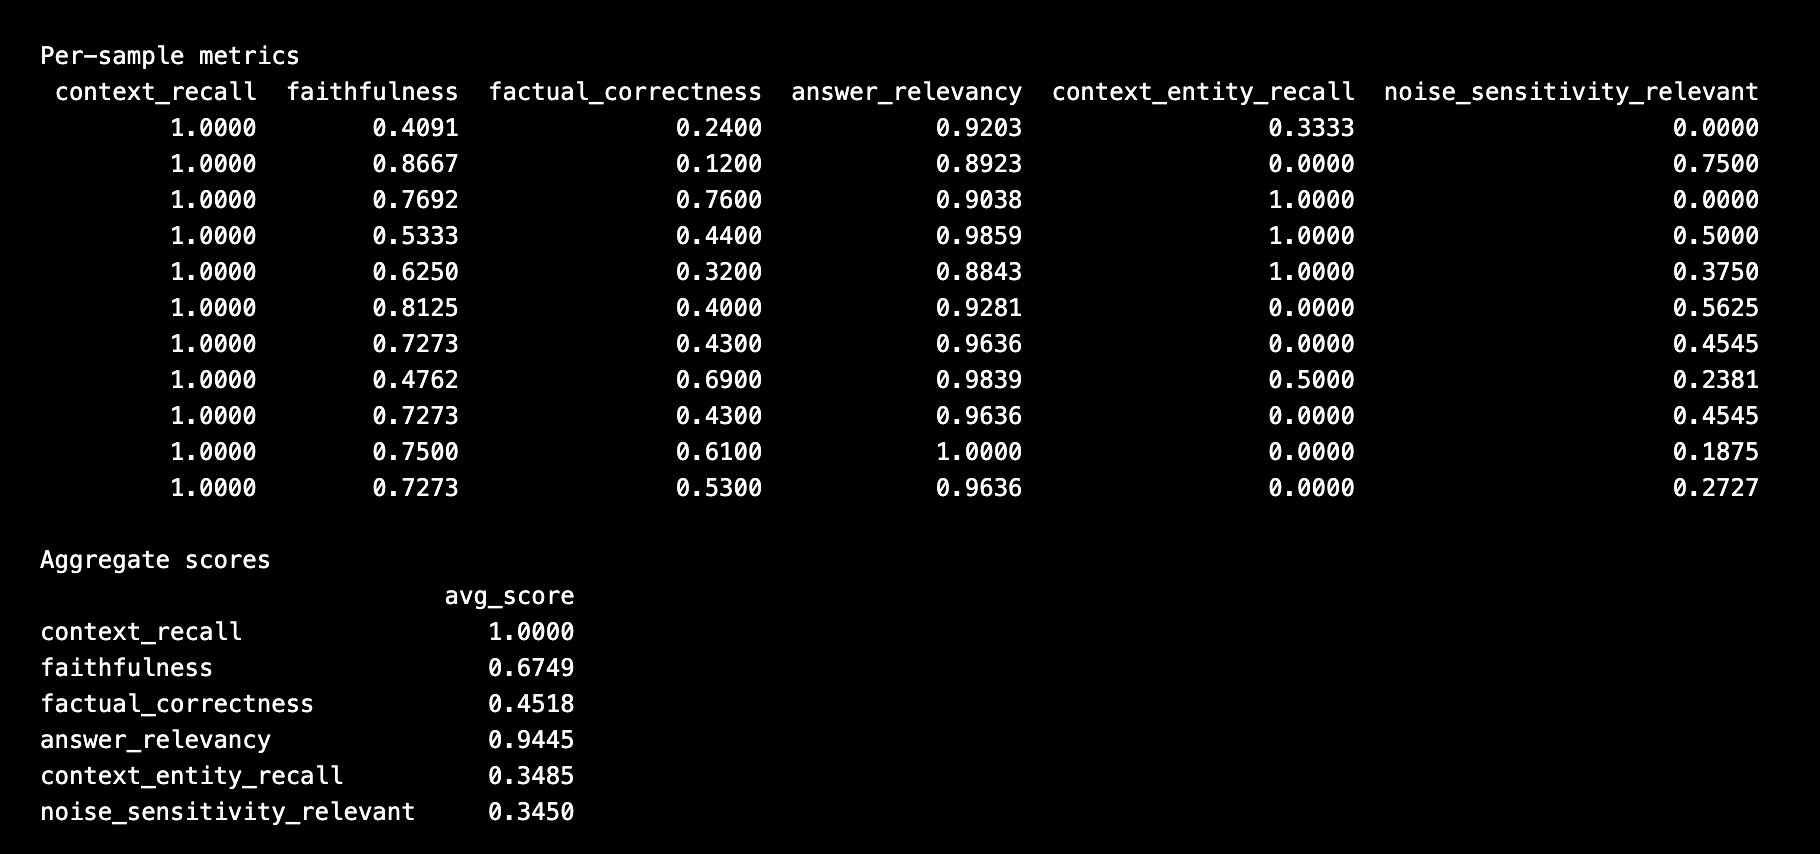

In [ ]:
## parent document retriever

from IPython.display import Image, display

display(Image(filename="ragas/5parentdocument.png"))

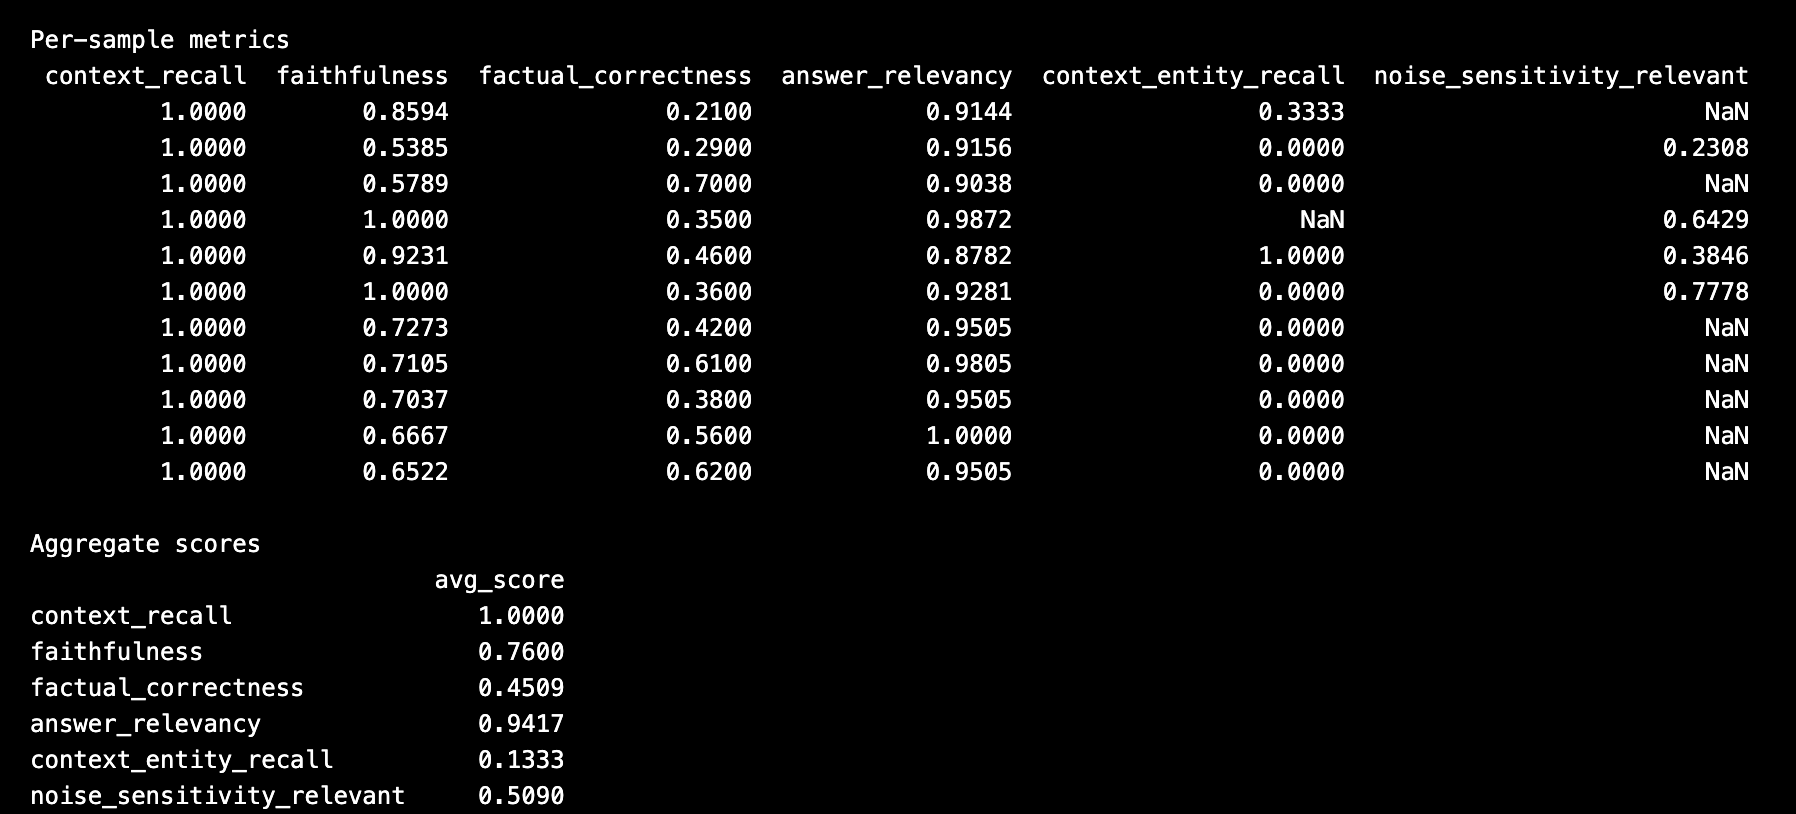

In [ ]:
## ensemble

from IPython.display import Image, display

display(Image(filename="ragas/6ensemble.png"))

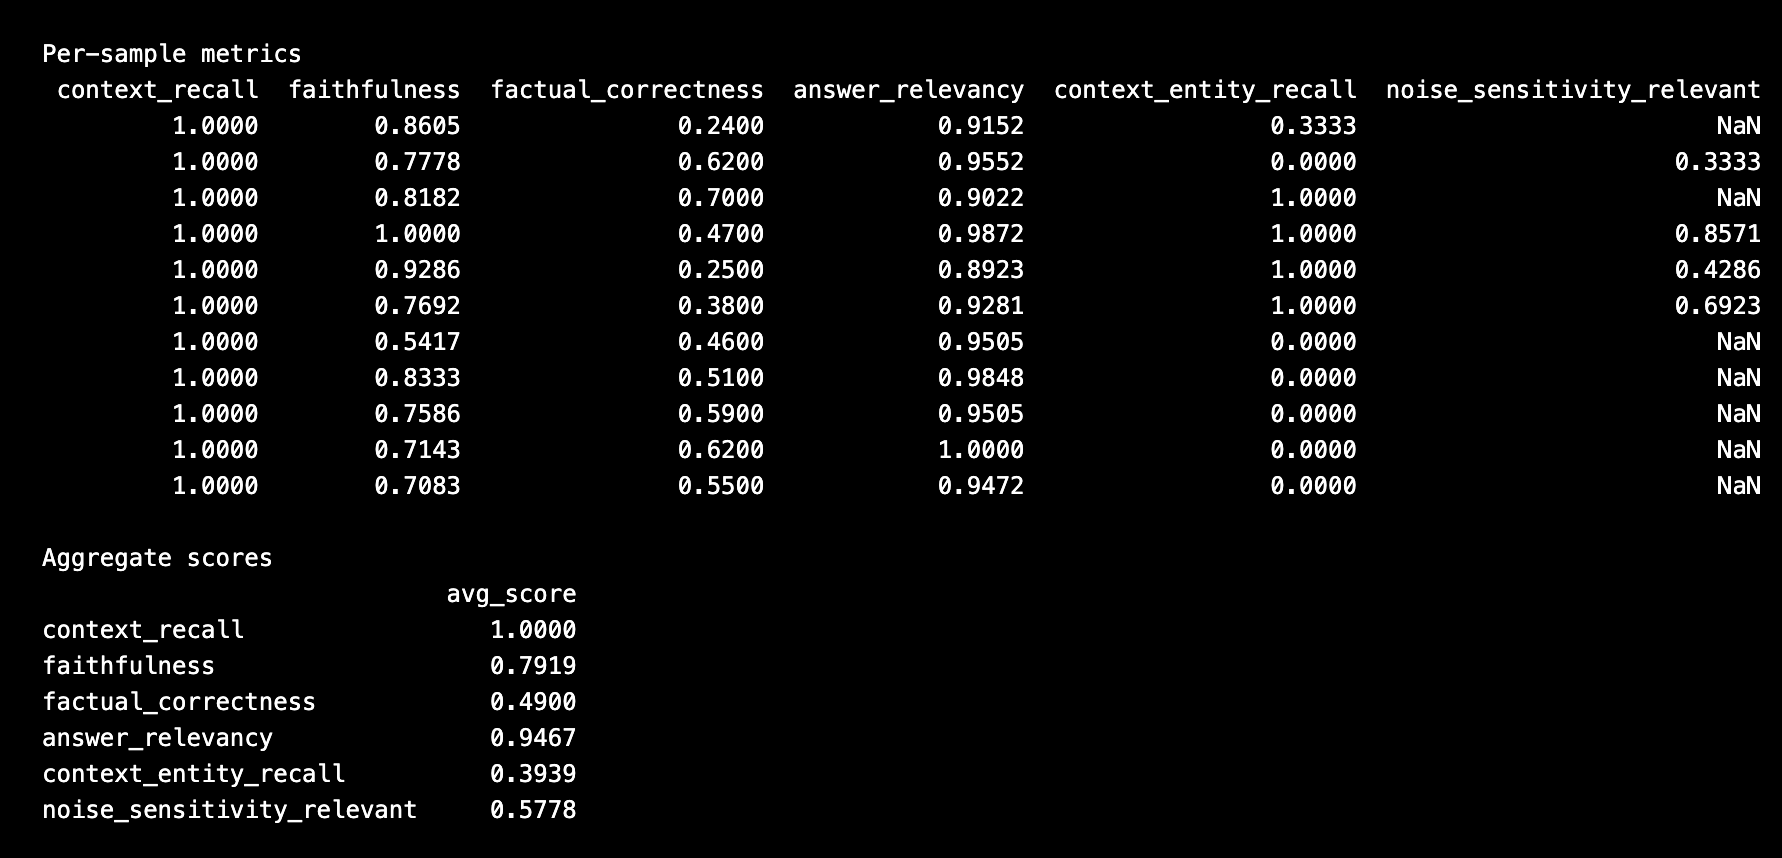

In [ ]:
## semantic retrieval

from IPython.display import Image, display

display(Image(filename="ragas/7semanticretrieval.png"))